In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.io
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from skimage import io , metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def normalize(v):
    return v / np.sqrt(v.dot(v))

def generate_phi():
    np.random.seed(333)
    phi= np.random.normal( size=(272,1089))
    n = len(phi)

    # perform Gramm-Schmidt orthonormalization

    phi[0, :] = normalize(phi[0, :])

    for i in range(1, n):
        Ai = phi[i, :]
        for j in range(0, i):
            Aj = phi[j, :]
            t = Ai.dot(Aj)
            Ai = Ai - t * Aj
        phi[i, :] = normalize(Ai)

    return phi

def divide_img_to_blocks(image, stride=14, filter_size=33):
    (h,w) = image.shape
    image = image[0:h-h%3, 0:w-w%3]
    (h,w) = image.shape
    h_iters = ((h - filter_size) // stride) + 1
    w_iters = ((w - filter_size) // stride) + 1
    blocks = []
    for i in range(h_iters):
        for j in range(w_iters):
            blocks.append(image[stride*i:filter_size+stride*i, stride*j:filter_size+stride*j])

    return np.asarray(blocks)

In [ ]:
#%% CREATE DATASET

# Read data and create patches
image_dataset = []
pics = sorted(os.listdir("/content/drive/MyDrive/BSDS200"))
for pic in pics:
    image= cv2.imread("/content/drive/MyDrive/BSDS200"+'/'+pic)
    image_lum = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    image_lum = cv2.normalize(image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    image_lum = image_lum[:,:,0]
    blocks = divide_img_to_blocks(image_lum)
    image_dataset.append(blocks)

image_dataset = np.concatenate(image_dataset, axis=0)

#A = scipy.io.loadmat("/content/drive/MyDrive/phi_0_25_1089.mat")["phi"]

A = generate_phi()

labels = np.copy(image_dataset)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, image_dataset, test_size=0.1, random_state=333)

In [ ]:
train_dataset=tf.Variable(X_train,dtype=tf.float32)

train_label=tf.Variable(y_train,dtype=tf.float32)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
dataset_y=tf.data.Dataset.from_tensor_slices(train_label)
#dataset = dataset.shuffle(num)
#dataset = dataset.batch(batch_size=128,drop_remainder=True)

In [ ]:
len(X_test)

13440

In [ ]:
#tf.compat.v1.disable_eager_execution()

In [ ]:

A1 = tf.Variable(A.T, dtype=tf.float32)

#x = tf.compat.v1.placeholder(tf.float32, shape=[None, 33, 33], name='x')
#x_comp = tf.matmul(tf.reshape(,(-1,33*33)), A1)

In [ ]:
A1.shape

TensorShape([1089, 272])

In [ ]:
for_comp=dataset.map(lambda x:tf.reshape(x,(1,33*33)))



In [ ]:
for_comp

<_MapDataset element_spec=TensorSpec(shape=(1, 1089), dtype=tf.float32, name=None)>

In [ ]:
def mult(x):
    return tf.matmul(x,A1)

In [ ]:
x_comp=for_comp.map(mult)

In [ ]:
x_comp

<_MapDataset element_spec=TensorSpec(shape=(1, 272), dtype=tf.float32, name=None)>

In [ ]:
train_x=[]
for i in x_comp:
    train_x.append(i)

In [ ]:
len(train_x)

120960

In [ ]:
dataset_y=dataset_y.map(lambda x: tf.expand_dims(x,axis=-1))

In [ ]:
dataset_y

<_MapDataset element_spec=TensorSpec(shape=(33, 33, 1), dtype=tf.float32, name=None)>

In [ ]:
len(dataset_y)

120960

In [ ]:
train_y=[]
for i in dataset_y:
    train_y.append(i)

In [ ]:
len(train_y)

120960

# Building model

In [ ]:
def my_model():
    inputs=keras.Input(shape=(272))
    e1 = tf.keras.layers.Dense(units=1089, activation=tf.nn.relu,)(inputs)
    e1 = tf.reshape(e1,(-1, 33,33,1))
    e2 = tf.keras.layers.Conv2D(64, 11, padding='same', activation=tf.nn.relu,
                              )(e1)
    e3 = tf.keras.layers.Conv2D(32, 1, padding='same', activation=tf.nn.relu,
                              )(e2)
    e4 = tf.keras.layers.Conv2D(1, 7, padding='same', activation=tf.nn.relu,
                              )(e3)
    e5 = tf.keras.layers.Conv2D(64, 11, padding='same', activation=tf.nn.relu,
                              )(e4)
    e6 = tf.keras.layers.Conv2D(32, 1, padding='same', activation=tf.nn.relu,
                              )(e5)
    e7 = tf.keras.layers.Conv2D(1, 7, padding='same', activation=tf.nn.relu,
                              )(e6)


    model=keras.Model(inputs=inputs,outputs=e7)

    return model

In [ ]:
model_1=my_model()

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 272)]             0         
                                                                 
 dense (Dense)               (None, 1089)              297297    
                                                                 
 tf.reshape (TFOpLambda)     (None, 33, 33, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 33, 33, 64)        7808      
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 32)        2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 1)         1569      
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 64)        7808  

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        loss = tf.reduce_mean(tf.math.squared_difference(y_pred, y_true))
        return loss
    return contrastive_loss

In [ ]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.compat.v1.train.exponential_decay(1e-3, global_step,
                                           100000, 0.9, staircase=True)
model_1.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001))
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [ ]:
train_x=tf.convert_to_tensor(train_x)
train_y=tf.convert_to_tensor(train_y)

In [ ]:
train_x=tf.reshape(train_x,shape=(120960,272))

In [ ]:
train_x.shape

TensorShape([120960, 272])

In [ ]:
train_y.shape

TensorShape([120960, 33, 33, 1])

In [ ]:
history=model_1.fit(train_x, train_y,epochs=300,batch_size=64)

Epoch 1/300
1890/1890 [==============================] - 23s 12ms/step - loss: 0.0024
Epoch 2/300
1890/1890 [==============================] - 23s 12ms/step - loss: 0.0024
Epoch 3/300
1890/1890 [==============================] - 22s 12ms/step - loss: 0.0024
Epoch 4/300
1890/1890 [==============================] - 22s 12ms/step - loss: 0.0024
Epoch 5/300
1890/1890 [==============================] - 22s 12ms/step - loss: 0.0024
Epoch 6/300
1890/1890 [==============================] - 23s 12ms/step - loss: 0.0024
Epoch 7/300
1890/1890 [==============================] - 23s 12ms/step - loss: 0.0024
Epoch 8/300
1890/1890 [==============================] - 22s 12ms/step - loss: 0.0024
Epoch 9/300
1890/1890 [==============================] - 22s 12ms/step - loss: 0.0024
Epoch 10/300
1890/1890 [==============================] - 23s 12ms/step - loss: 0.0024
Epoch 11/300
1890/1890 [==============================] - 23s 12ms/step - loss: 0.0024
Epoch 12/300
1890/1890 [============================

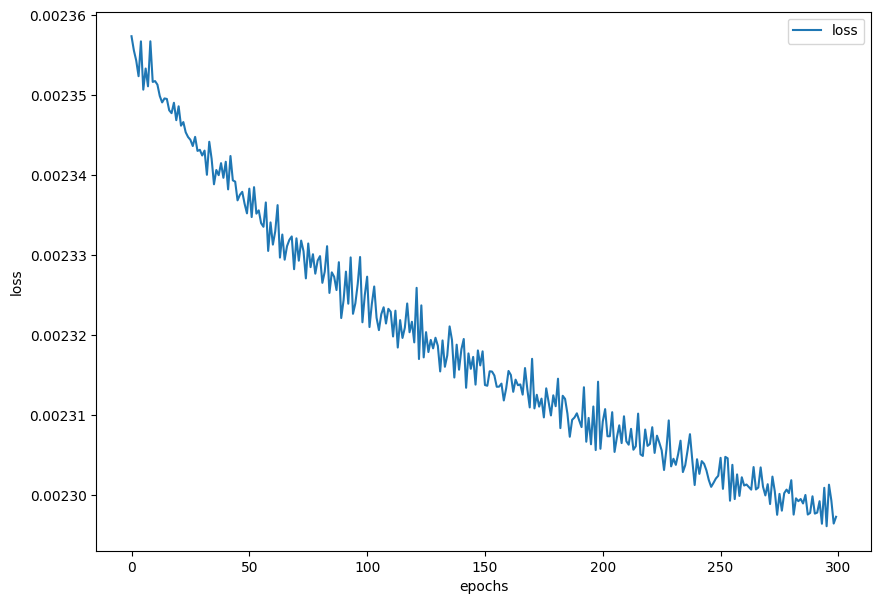

In [ ]:
import pandas as pd
# Checkout the history
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs",ylabel="loss");

# PSNR

In [ ]:
def psnr(img1, img2):
    img1=img1.astype(float)
    img2=img2.astype(float)
    mse=mean_squared_error(img1,img2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# For Gray scale image

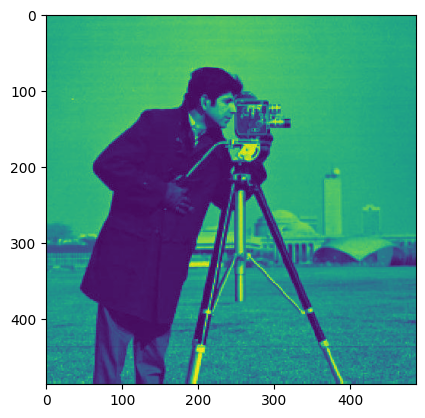

In [ ]:
path="/content/cameraman.jpeg"
img=cv2.imread(path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
img_lum=img[:,:,0]
plt.imshow(img_lum)

In [ ]:
blocks_cam=divide_img_to_blocks(img_lum)
blocks_cam.shape

(1089, 33, 33)

In [ ]:
cs_comp=tf.Variable(blocks_cam,dtype=tf.float32)

In [ ]:
cs_comp.shape

TensorShape([1089, 33, 33])

In [ ]:
cam_comp=tf.reshape(cs_comp,(cs_comp.shape[0],1089))

In [ ]:
cam_comp.shape

TensorShape([1089, 1089])

In [ ]:
A1.shape

TensorShape([1089, 272])

In [ ]:
blocks_cam_test=tf.expand_dims(blocks_cam,axis=-1)
blocks_cam_test.shape

TensorShape([1089, 33, 33, 1])

In [ ]:
cs_cam=tf.matmul(cam_comp,A1)

In [ ]:
cs_cam.shape

TensorShape([1089, 272])

In [ ]:
result_cam=model_1.predict(cs_cam)

35/35 [==============================] - 1s 6ms/step


In [ ]:
result_cam.shape

(1089, 33, 33, 1)

In [ ]:
!pip install bm3d
import bm3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00


In [ ]:
denoise=[]
for i in range(len(result_cam)):
    denoise.append(bm3d.bm3d(result_cam[i],sigma_psd=0.1,stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING))

In [ ]:
len(denoise)

1089

# Reconstruction Images




In [ ]:
# %% RECONSTRUCT IMAGES
test_image = cv2.imread(path)
test_image_lum = cv2.cvtColor(test_image, cv2.COLOR_BGR2YCR_CB)
test_image_lum = test_image_lum[:,:,0]
test_image_lum = cv2.normalize(test_image_lum.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
test_gray = cv2.imread(path,0)
filter_size = 33
stride = 14
(h,w) = test_image_lum.shape
h_iters = ((h - filter_size) // stride) + 1
w_iters = ((w - filter_size) // stride) + 1
recon_img = np.zeros((h,w))

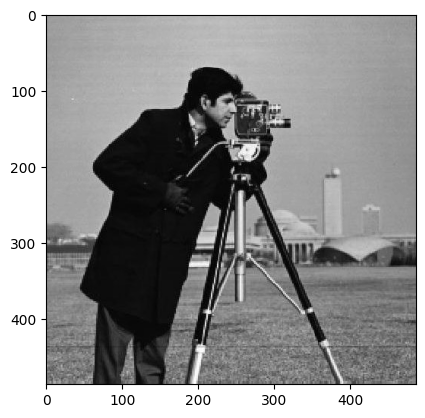

In [ ]:
a=plt.imshow(test_gray,cmap="gray")

In [ ]:
tf.math.reduce_max(test_gray)

<tf.Tensor: shape=(), dtype=uint8, numpy=255>

In [ ]:
c=-1

In [ ]:
for i in range(h_iters):
    for j in range(w_iters):
        #feed = np.expand_dims(test_image_lum[stride*i:filter_size+stride*i, stride*j:filter_size+stride*j],axis=0)
        c=c+1
        out=result_cam[c]
        out = np.squeeze(out)
        recon_img[stride*i:filter_size+stride*i, stride*j:filter_size+stride*j] = out

In [ ]:
recon_img


array([[0.61676592, 0.61263645, 0.60961783, ..., 0.        , 0.        ,
        0.        ],
       [0.62034404, 0.62018776, 0.62058407, ..., 0.        , 0.        ,
        0.        ],
       [0.6241796 , 0.62755811, 0.6240803 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *(sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [ ]:
def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
recon_img=recon_img*255.
print(f"PSNR of the  img is  {psnr(recon_img,test_gray)}")

PSNR of the  img is  21.21845737811412


PSNR of the Reconstruced image and ground truth image with applying denoise filter is 21.21845737811412, for 1000 epochs


(-0.5, 486.5, 486.5, -0.5)

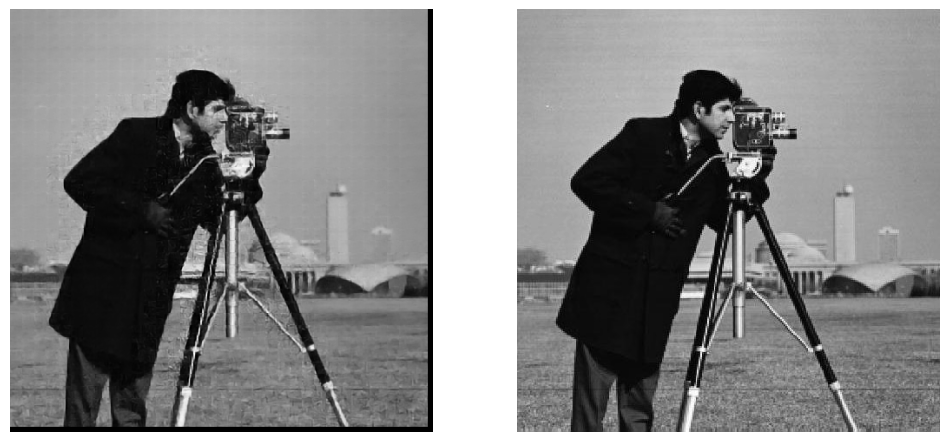

In [ ]:
print(f"PSNR of the Reconstruced image and ground truth image with applying denoise filter is {psnr(recon_img,test_gray)}, for 1000 epochs")
plt.figure(figsize=(12,17))
plt.subplot(2,2,1)
plt.imshow(recon_img,cmap='gray')
plt.axis("off")
plt.subplot(2,2,2)
plt.imshow(test_gray,cmap='gray')
plt.axis("off")



In [ ]:
ssim = metrics.structural_similarity(test_gray, recon_img, multichannel=True)
print("SSIM", ssim)

<ipython-input-70-c84a4d37e68f>:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = metrics.structural_similarity(test_gray, recon_img, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SSIM 0.8004820887640692
